In [1]:
import pathlib

from sympy import beta

# Define data directory
train_dir = pathlib.Path('data/original/train')
test_dir = pathlib.Path('data/original/test')
train_masks_dir = pathlib.Path('external_contours_masks/train')
test_masks_dir = pathlib.Path('external_contours_masks/test')

In [2]:
# Convert all the images in train masks and test masks to png
import os
from PIL import Image

for img_path in train_masks_dir.glob('*.jpg'):
    os.remove(img_path)

for img_path in test_masks_dir.glob('*.jpg'):
    os.remove(img_path)

In [3]:
import os
import cv2
import numpy as np

# check if the pixels are normalized
img = cv2.imread(os.path.join(test_dir, 'P1MF1_C.Png'), cv2.IMREAD_GRAYSCALE)
print(np.max(img), np.min(img))
img_mask = cv2.imread(os.path.join(test_masks_dir, 'P1MF1_C.Png'), cv2.IMREAD_GRAYSCALE)
print(np.max(img_mask), np.min(img_mask))
print(img.shape, img_mask.shape)

255 0
233 0
(4096, 4096) (4096, 4096)


In [4]:
X_train = []
y_train = []
X_test = []
y_test = []

for img_path in train_dir.glob('*.png'):
    img = cv2.imread(str(img_path))
    img = cv2.resize(img, (256, 256))
    X_train.append(img)
    mask_path = os.path.join(train_masks_dir, img_path.stem + '.Png')
    img_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    img_mask = cv2.resize(img_mask, (256, 256))
    y_train.append(img_mask)

for img_path in test_dir.glob('*.png'):
    img = cv2.imread(str(img_path))
    img = cv2.resize(img, (256, 256))
    X_test.append(img)
    mask_path = os.path.join(test_masks_dir, img_path.stem + '.Png')
    img_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    img_mask = cv2.resize(img_mask, (256, 256))
    y_test.append(img_mask)

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# # Expand the dimensions of the images
#X_train = np.expand_dims(X_train, axis = 3)
y_train = np.expand_dims(y_train, axis = 3)
#X_test = np.expand_dims(X_test, axis = 3)
y_test = np.expand_dims(y_test, axis = 3)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(50, 256, 256, 3) (50, 256, 256, 1)
(13, 256, 256, 3) (13, 256, 256, 1)


In [5]:
from random import random
import tensorflow as tf
# random seed
SEED = 42

def reset_random_seeds():
   os.environ['PYTHONHASHSEED']=str(SEED)
   tf.random.set_seed(SEED)
   tf.keras.utils.set_random_seed(SEED)
   np.random.seed(SEED)
   tf.config.experimental.enable_op_determinism()

reset_random_seeds()
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [6]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask = tf.round(tf.cast(input_mask, tf.float32) / 255.0)
    return input_image, input_mask

def load_image(input_image, input_mask):
    input_image = tf.image.resize(input_image, (128, 128))
    input_mask = tf.image.resize(input_mask,(128, 128), method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

In [7]:
TRAIN_LENGTH = len(X_train)
BATCH_SIZE = 4
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [8]:
train_ds = train_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_ds = test_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

print("the shape of the train dataset is: ", train_ds)
# Show the labels of the first image
for image, mask in train_ds.take(1):
    print(" median value of the image is: ", np.median(mask.numpy()))
    # print("the shape of the image is: ", image.numpy().shape)
    # print("the shape of the mask is: ", mask.numpy().shape)
    # print("the label of the first image is: ", mask.numpy())

the shape of the train dataset is:  <_ParallelMapDataset element_spec=(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(128, 128, 1), dtype=tf.float32, name=None))>
 median value of the image is:  1.0


In [9]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    # do augmentation in ratio of 1 to 5 images in the train
    self.augment_inputs = tf.keras.Sequential([
        # tf.keras.layers.RandomFlip(mode="horizontal", seed=seed),
        # tf.keras.layers.RandomRotation(factor=0.2, seed=seed),
        # tf.keras.layers.RandomZoom(height_factor=0.2, width_factor=0.2, seed=seed),
        # tf.keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2, seed=seed),
        # tf.keras.layers.RandomContrast(factor=0.2, seed=seed),
    ], name="augment_inputs")

    self.augment_labels = tf.keras.Sequential([
        # tf.keras.layers.RandomFlip(mode="horizontal", seed=seed),
        # tf.keras.layers.RandomRotation(factor=0.2, seed=seed),
        # tf.keras.layers.RandomZoom(height_factor=0.2, width_factor=0.2, seed=seed),
        # tf.keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2, seed=seed),
    ], name="augment_labels")

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

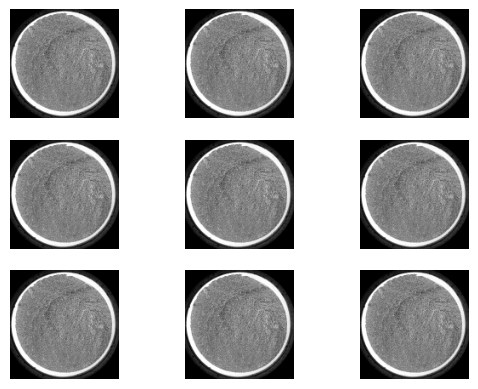

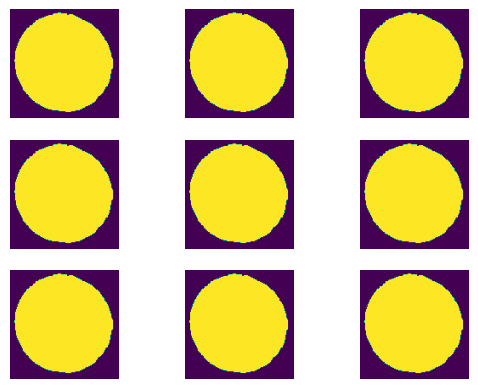

In [10]:
from matplotlib import pyplot as plt
# plot 9 augmentations of the image and the mask for one original image and its mask
for image, mask in train_ds.take(1):
    # random seed array
    seed = np.random.randint(0, 1000, 9)
    for i in range(9):
        plt.subplot(330 + 1 + i)
        augmented_image, augmented_mask = Augment(seed[i])(image, mask)
        plt.imshow(augmented_image.numpy())
        plt.axis("off")
    plt.show()
    for i in range(9):
        plt.subplot(330 + 1 + i)
        augmented_image, augmented_mask = Augment(seed[i])(image, mask)
        plt.imshow(augmented_mask.numpy())
        plt.axis("off")
    plt.show()

In [11]:
train_batches = (
    train_ds
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches, val_batches = test_ds.take(len(X_test) // 2).batch(BATCH_SIZE), test_ds.skip(len(X_test) // 2).batch(BATCH_SIZE)

In [12]:
from matplotlib import pyplot as plt

def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    # print the unique values of the image
    #print(np.unique(display_list[i]))
    plt.axis('off')
  plt.show()

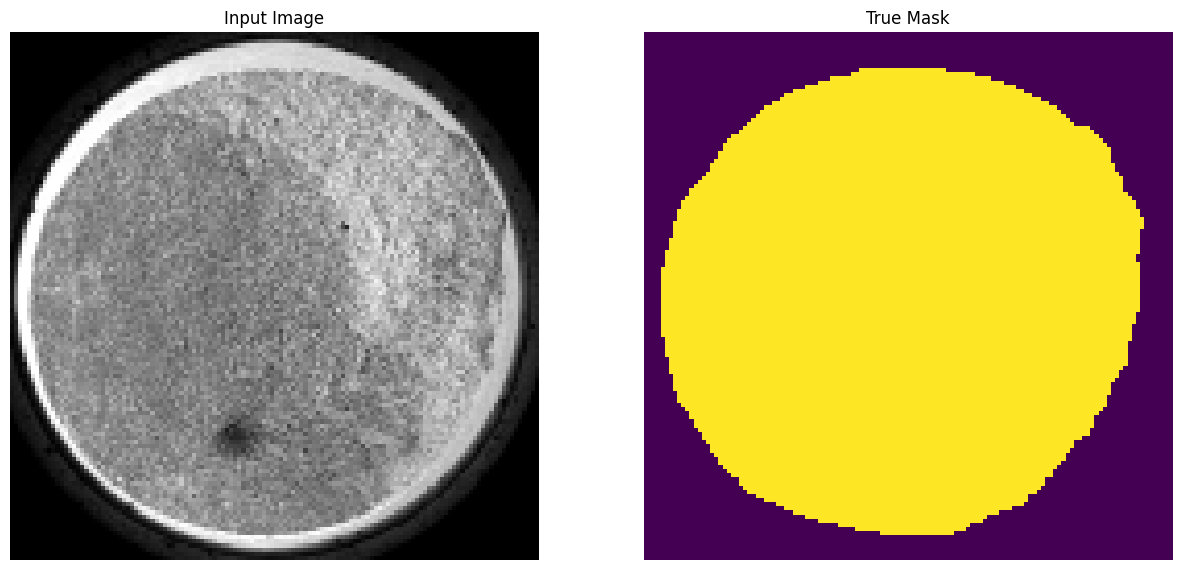

In [13]:
for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

In [14]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

# Make the last two layers trainable, but keep the rest frozen
for layer in down_stack.layers:  # Exclude the last two layers
    layer.trainable = False

# # Now, set the last two layers to be trainable
# for layer in down_stack.layers[-1:]:
#     layer.trainable = True

In [15]:
from tensorflow_examples.models.pix2pix import pix2pix

up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
    pix2pix.upsample(32, 3),   # 64x64 -> 128x128
]

# Make the last two layers of the up_stack trainable, but keep the rest frozen
# for layer in up_stack[0:0]:  # Exclude the last two layers
#     layer.trainable = False

# # Now, set the last two layers to be trainable
for layer in up_stack:
    layer.trainable = True


In [16]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [17]:
# Try the model
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [18]:
class WeightedSCCE(tf.keras.losses.Loss):
    def __init__(self, class_weight, from_logits=False, name='weighted_scce'):
        if class_weight is None or all(v == 1. for v in class_weight):
            self.class_weight = None
        else:
            self.class_weight = tf.convert_to_tensor(class_weight,
                dtype=tf.float32)
        self.name = name
        self.reduction = tf.keras.losses.Reduction.NONE
        self.unreduced_scce = tf.keras.losses.SparseCategoricalCrossentropy(
            from_logits=from_logits, name=name,
            reduction=self.reduction)

    def __call__(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, dtype=tf.int32)
        loss = self.unreduced_scce(y_true, y_pred, sample_weight)
        if self.class_weight is not None:
            weight_mask = tf.gather(self.class_weight, y_true)
            loss = tf.math.multiply(loss, weight_mask)
        return loss


In [19]:
import tensorflow as tf
# Assuming OUTPUT_CLASSES is the number of classes in your segmentation task
OUTPUT_CLASSES = 2

# Create the U-Net model
model = unet_model(output_channels=OUTPUT_CLASSES)

# Compile the model
model.compile(optimizer='adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 0s 129ms/step


1/1 [==============================] - 0s 133ms/step


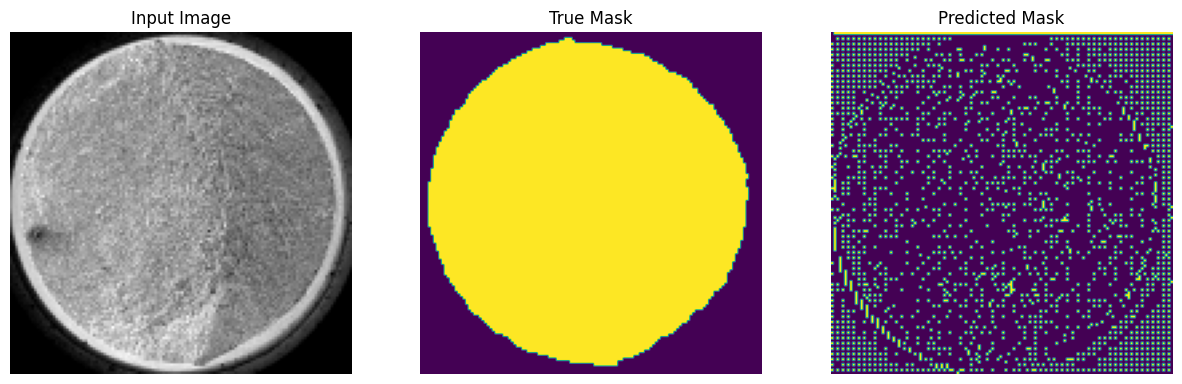

In [21]:
show_predictions(train_batches, 3)

In [22]:
from IPython.display import clear_output

class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    #clear_output(wait=True)
    show_predictions(train_batches, 1)
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

Epoch 1/200
1/1 [==============================] - 0s 125ms/step



Sample Prediction after epoch 1

12/12 [==============================] - 11s 360ms/step - loss: 0.5540 - accuracy: 0.7106 - val_loss: 0.2873 - val_accuracy: 0.8603
Epoch 2/200
1/1 [==============================] - 0s 134ms/step



Sample Prediction after epoch 2

12/12 [==============================] - 3s 258ms/step - loss: 0.2024 - accuracy: 0.9405 - val_loss: 0.0790 - val_accuracy: 0.9801
Epoch 3/200
1/1 [==============================] - 0s 131ms/step


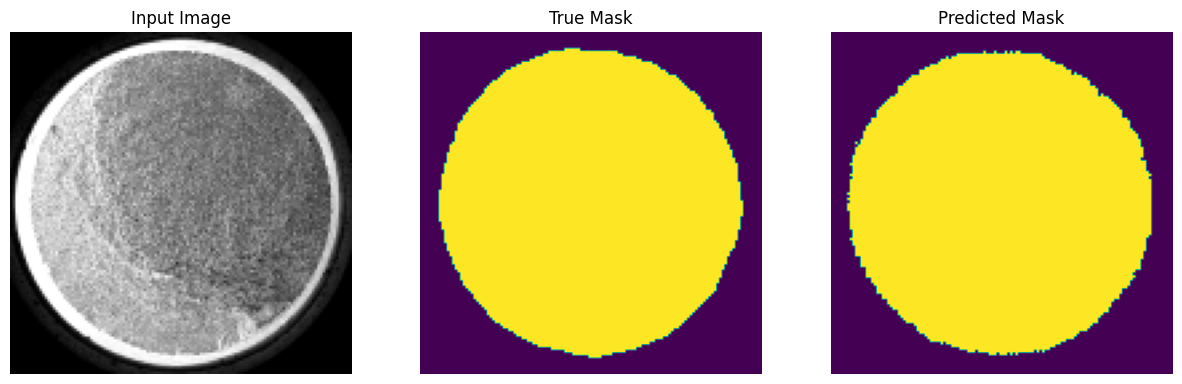


Sample Prediction after epoch 3

12/12 [==============================] - 3s 261ms/step - loss: 0.1037 - accuracy: 0.9806 - val_loss: 0.0479 - val_accuracy: 0.9842
Epoch 4/200
1/1 [==============================] - 0s 158ms/step


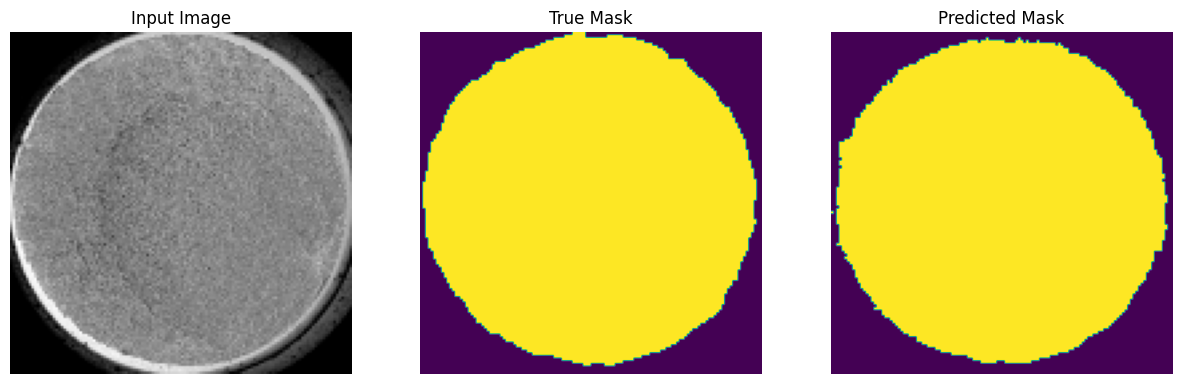


Sample Prediction after epoch 4

12/12 [==============================] - 3s 286ms/step - loss: 0.0692 - accuracy: 0.9838 - val_loss: 0.0499 - val_accuracy: 0.9821
Epoch 5/200
1/1 [==============================] - 0s 123ms/step


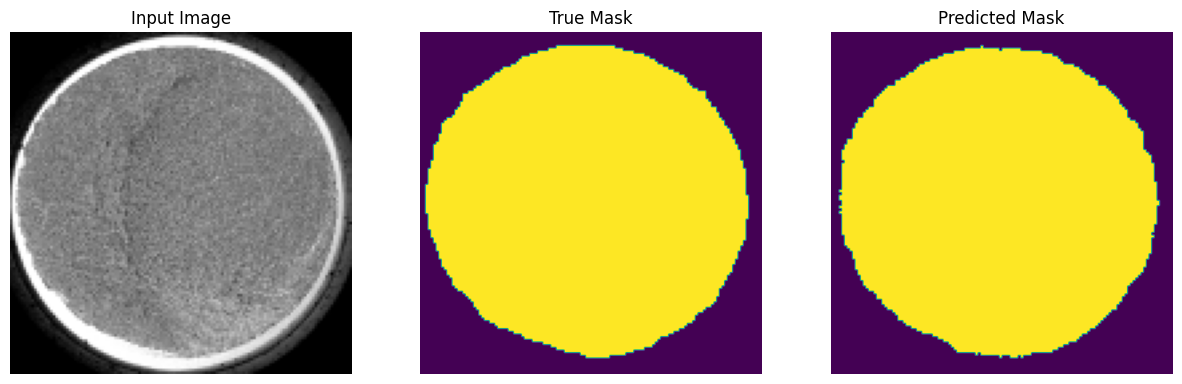


Sample Prediction after epoch 5

12/12 [==============================] - 3s 251ms/step - loss: 0.0548 - accuracy: 0.9847 - val_loss: 0.0379 - val_accuracy: 0.9865
Epoch 6/200
1/1 [==============================] - 0s 132ms/step


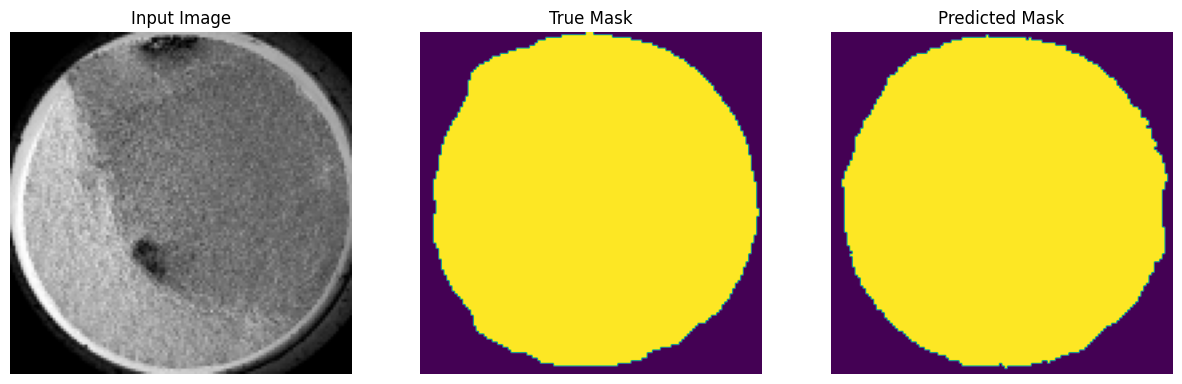


Sample Prediction after epoch 6

12/12 [==============================] - 3s 250ms/step - loss: 0.0472 - accuracy: 0.9862 - val_loss: 0.0426 - val_accuracy: 0.9848
Epoch 7/200
1/1 [==============================] - 0s 120ms/step


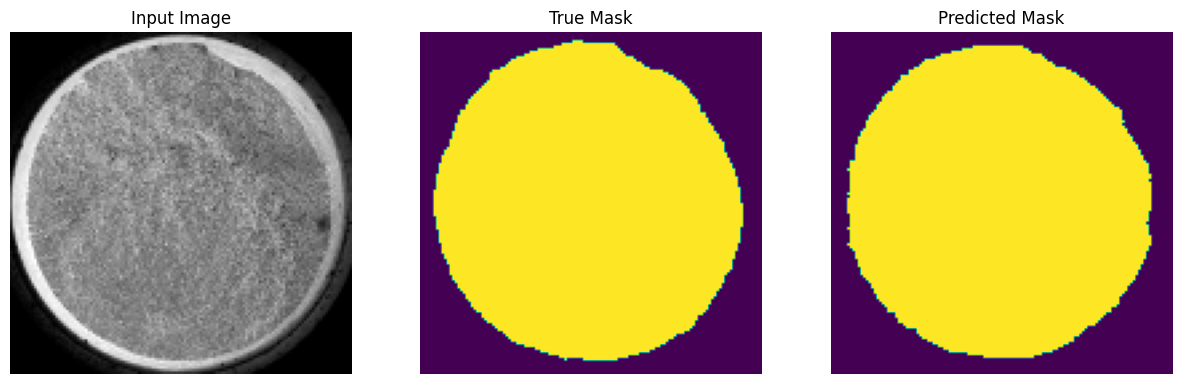


Sample Prediction after epoch 7

12/12 [==============================] - 3s 253ms/step - loss: 0.0407 - accuracy: 0.9873 - val_loss: 0.0422 - val_accuracy: 0.9844
Epoch 8/200
1/1 [==============================] - 0s 135ms/step



Sample Prediction after epoch 8

12/12 [==============================] - 3s 258ms/step - loss: 0.0382 - accuracy: 0.9873 - val_loss: 0.0428 - val_accuracy: 0.9845
Epoch 9/200
1/1 [==============================] - 0s 120ms/step


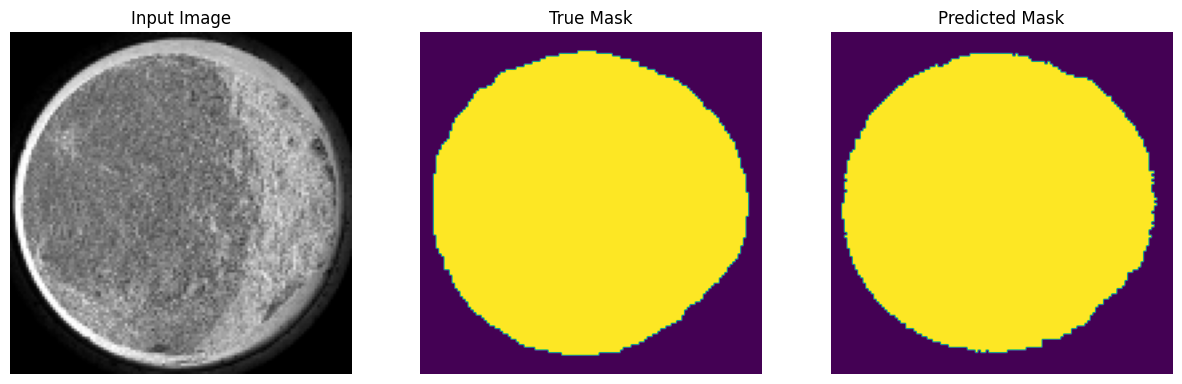


Sample Prediction after epoch 9

12/12 [==============================] - 3s 262ms/step - loss: 0.0354 - accuracy: 0.9882 - val_loss: 0.0427 - val_accuracy: 0.9846
Epoch 10/200
1/1 [==============================] - 0s 127ms/step



Sample Prediction after epoch 10

12/12 [==============================] - 3s 252ms/step - loss: 0.0322 - accuracy: 0.9891 - val_loss: 0.0403 - val_accuracy: 0.9854
Epoch 11/200
1/1 [==============================] - 0s 236ms/step


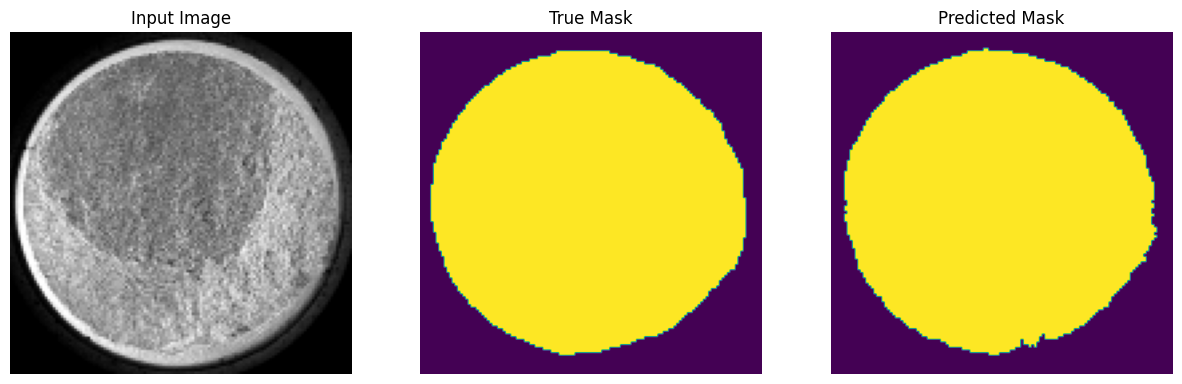


Sample Prediction after epoch 11

12/12 [==============================] - 3s 260ms/step - loss: 0.0307 - accuracy: 0.9894 - val_loss: 0.0356 - val_accuracy: 0.9868
Epoch 12/200
1/1 [==============================] - 0s 122ms/step



Sample Prediction after epoch 12

12/12 [==============================] - 3s 242ms/step - loss: 0.0296 - accuracy: 0.9895 - val_loss: 0.0341 - val_accuracy: 0.9872
Epoch 13/200
1/1 [==============================] - 0s 120ms/step


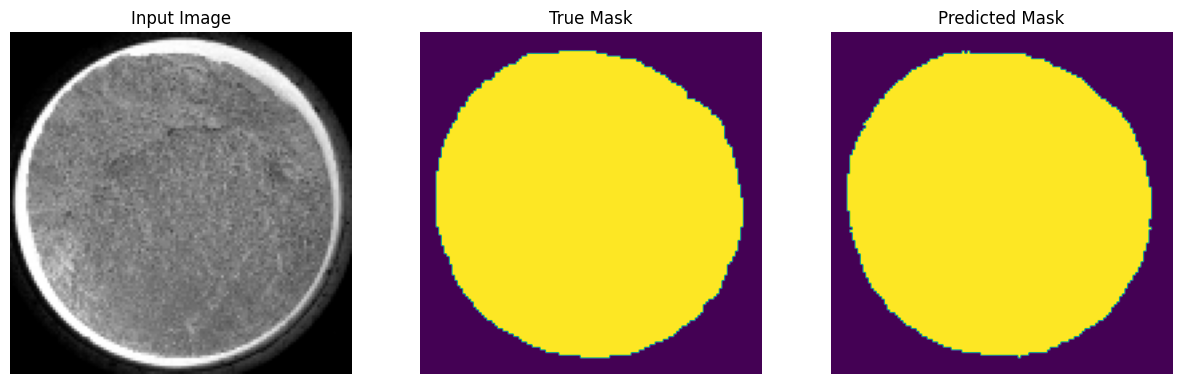


Sample Prediction after epoch 13

12/12 [==============================] - 3s 245ms/step - loss: 0.0280 - accuracy: 0.9899 - val_loss: 0.0394 - val_accuracy: 0.9858
Epoch 14/200
1/1 [==============================] - 0s 129ms/step


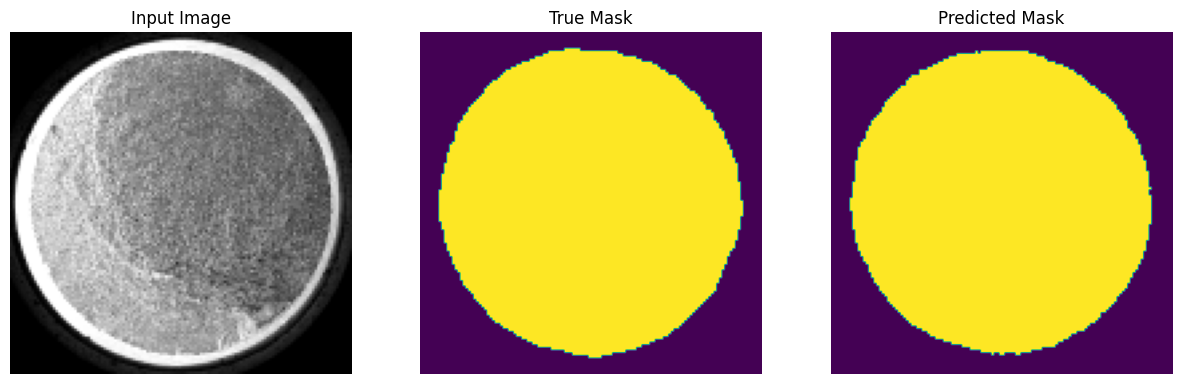


Sample Prediction after epoch 14

12/12 [==============================] - 3s 258ms/step - loss: 0.0269 - accuracy: 0.9902 - val_loss: 0.0365 - val_accuracy: 0.9863
Epoch 15/200
1/1 [==============================] - 0s 124ms/step


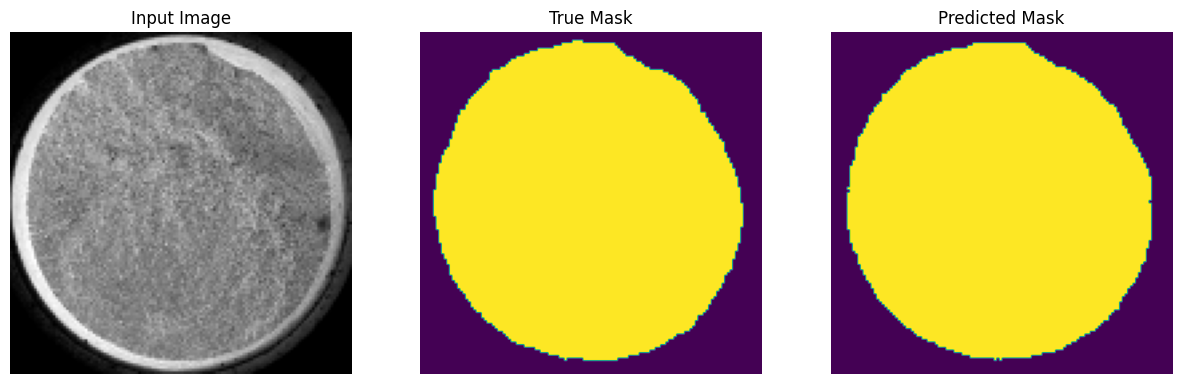


Sample Prediction after epoch 15

12/12 [==============================] - 3s 280ms/step - loss: 0.0257 - accuracy: 0.9905 - val_loss: 0.0335 - val_accuracy: 0.9878
Epoch 16/200
1/1 [==============================] - 0s 241ms/step


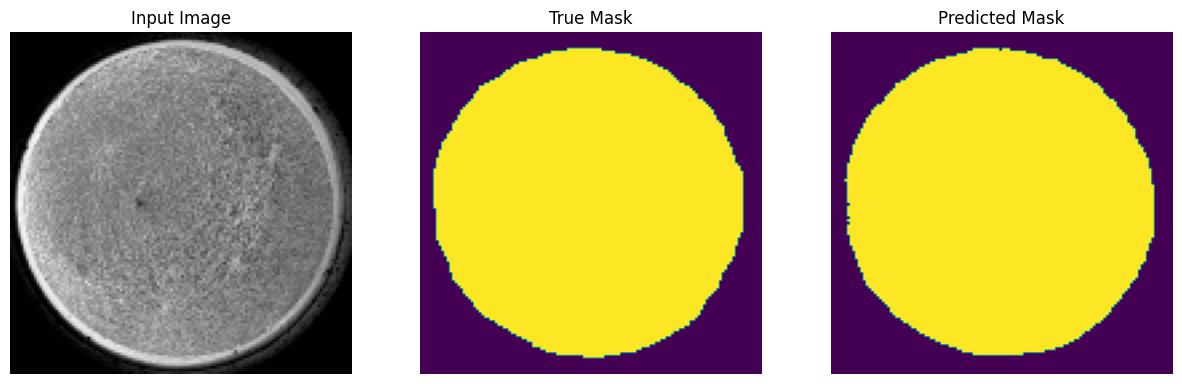


Sample Prediction after epoch 16

12/12 [==============================] - 4s 302ms/step - loss: 0.0255 - accuracy: 0.9905 - val_loss: 0.0312 - val_accuracy: 0.9882
Epoch 17/200
1/1 [==============================] - 0s 178ms/step


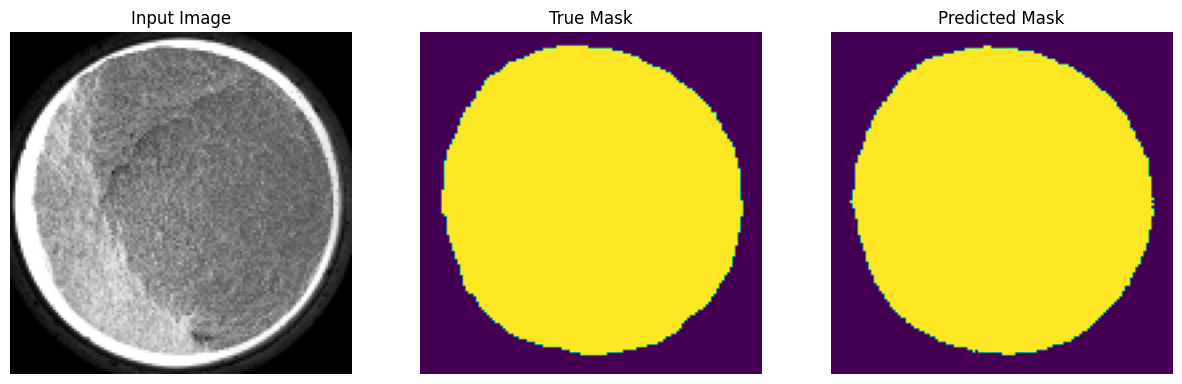


Sample Prediction after epoch 17

12/12 [==============================] - 4s 296ms/step - loss: 0.0236 - accuracy: 0.9913 - val_loss: 0.0355 - val_accuracy: 0.9867
Epoch 18/200
1/1 [==============================] - 0s 252ms/step


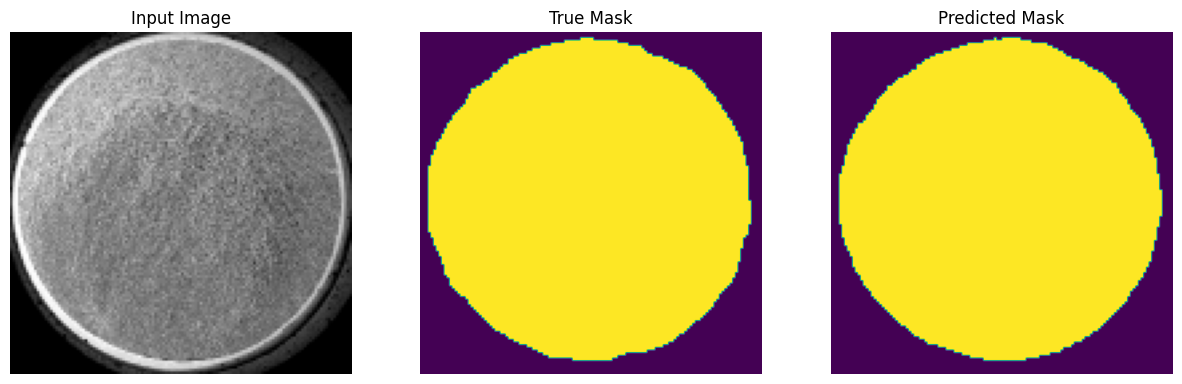


Sample Prediction after epoch 18

12/12 [==============================] - 3s 287ms/step - loss: 0.0245 - accuracy: 0.9907 - val_loss: 0.0351 - val_accuracy: 0.9871
Epoch 19/200
1/1 [==============================] - 0s 488ms/step


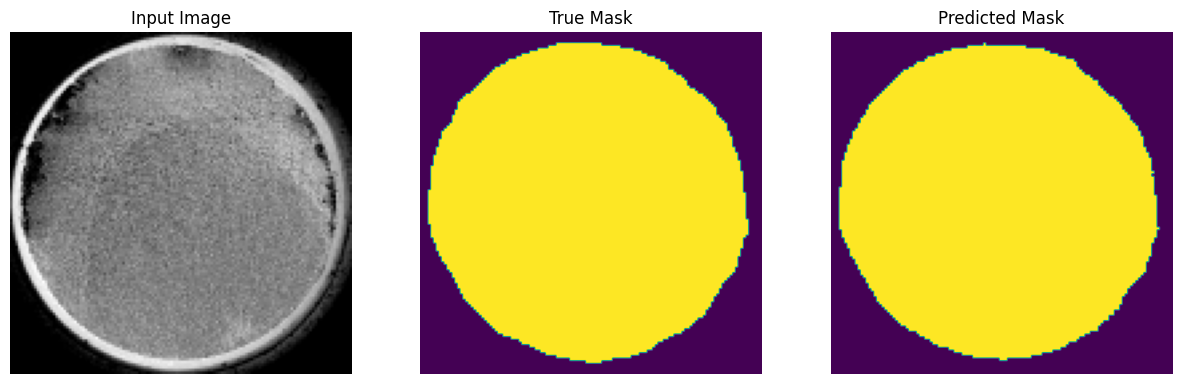


Sample Prediction after epoch 19

12/12 [==============================] - 4s 307ms/step - loss: 0.0237 - accuracy: 0.9910 - val_loss: 0.0309 - val_accuracy: 0.9882
Epoch 20/200
1/1 [==============================] - 0s 363ms/step


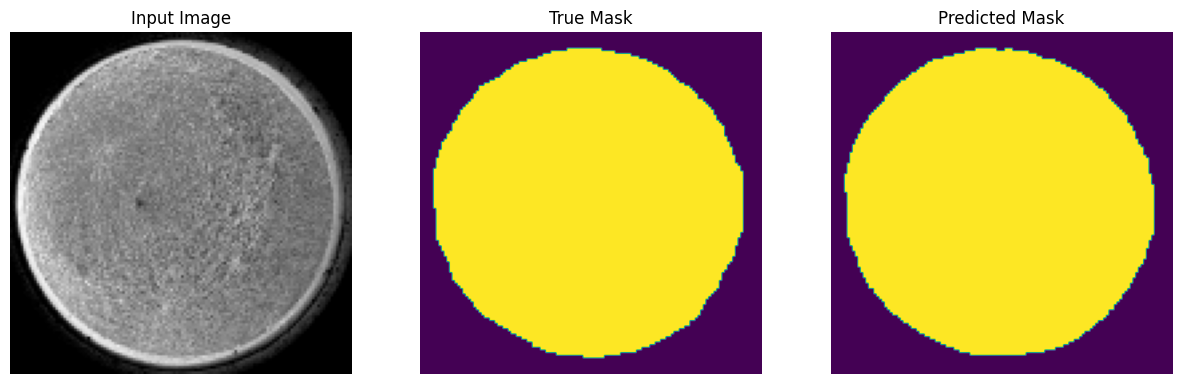


Sample Prediction after epoch 20

12/12 [==============================] - 3s 295ms/step - loss: 0.0211 - accuracy: 0.9920 - val_loss: 0.0311 - val_accuracy: 0.9884
Epoch 21/200
1/1 [==============================] - 0s 150ms/step


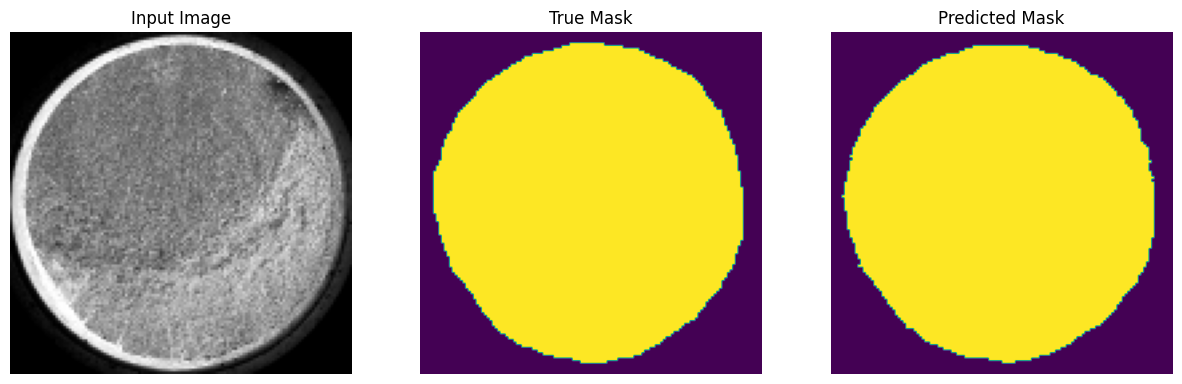


Sample Prediction after epoch 21

12/12 [==============================] - 3s 259ms/step - loss: 0.0223 - accuracy: 0.9915 - val_loss: 0.0310 - val_accuracy: 0.9882
Epoch 22/200
1/1 [==============================] - 0s 333ms/step


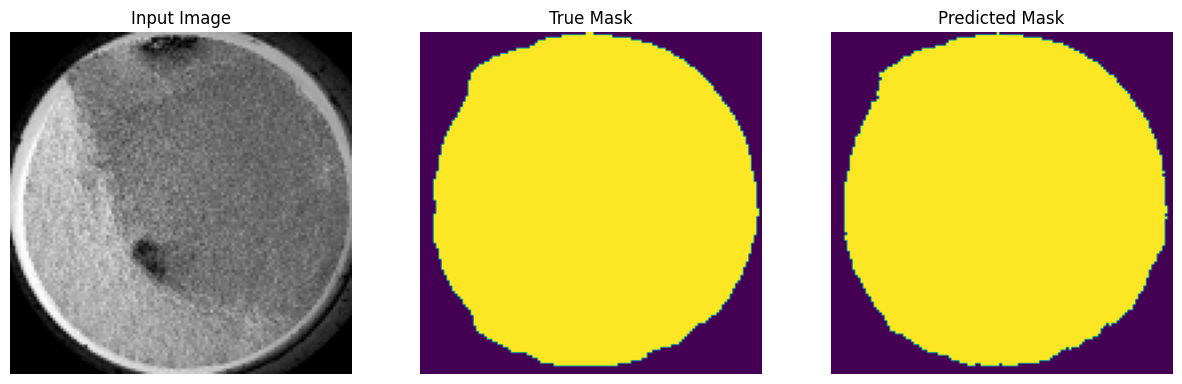


Sample Prediction after epoch 22

12/12 [==============================] - 4s 342ms/step - loss: 0.0221 - accuracy: 0.9914 - val_loss: 0.0331 - val_accuracy: 0.9877
Epoch 23/200
1/1 [==============================] - 0s 175ms/step


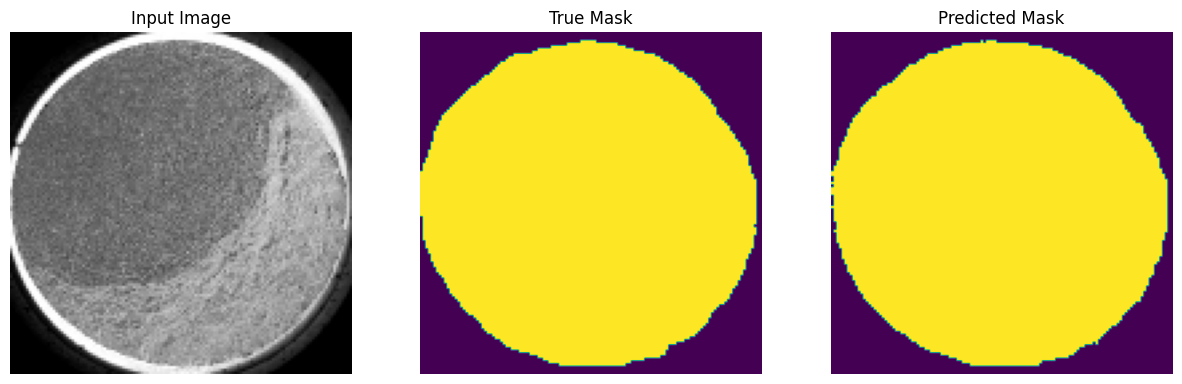


Sample Prediction after epoch 23

12/12 [==============================] - 3s 271ms/step - loss: 0.0211 - accuracy: 0.9919 - val_loss: 0.0313 - val_accuracy: 0.9881
Epoch 24/200
1/1 [==============================] - 0s 162ms/step


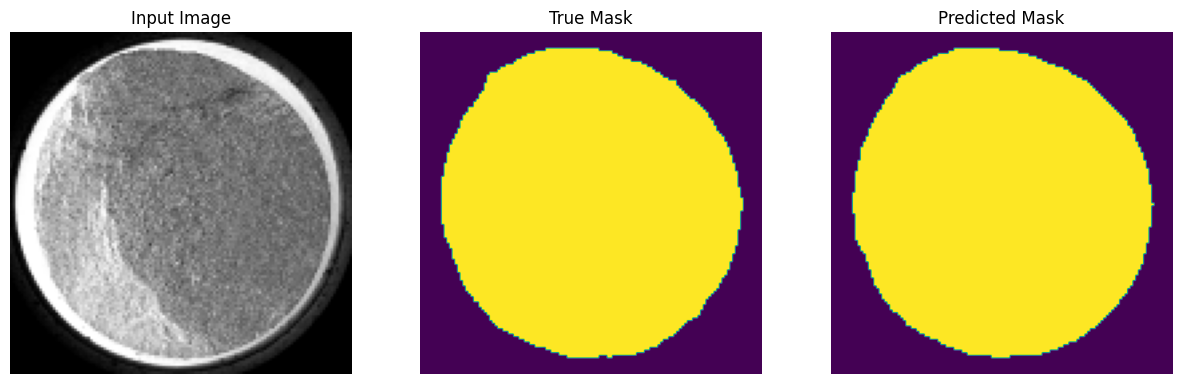


Sample Prediction after epoch 24

12/12 [==============================] - 3s 252ms/step - loss: 0.0207 - accuracy: 0.9920 - val_loss: 0.0319 - val_accuracy: 0.9879
Epoch 25/200
1/1 [==============================] - 0s 233ms/step


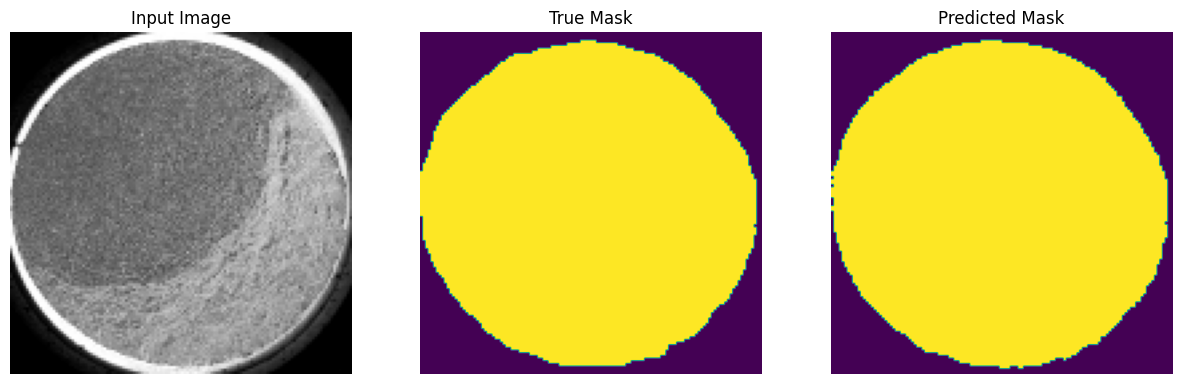


Sample Prediction after epoch 25

12/12 [==============================] - 3s 270ms/step - loss: 0.0205 - accuracy: 0.9920 - val_loss: 0.0331 - val_accuracy: 0.9874
Epoch 26/200
1/1 [==============================] - 1s 512ms/step


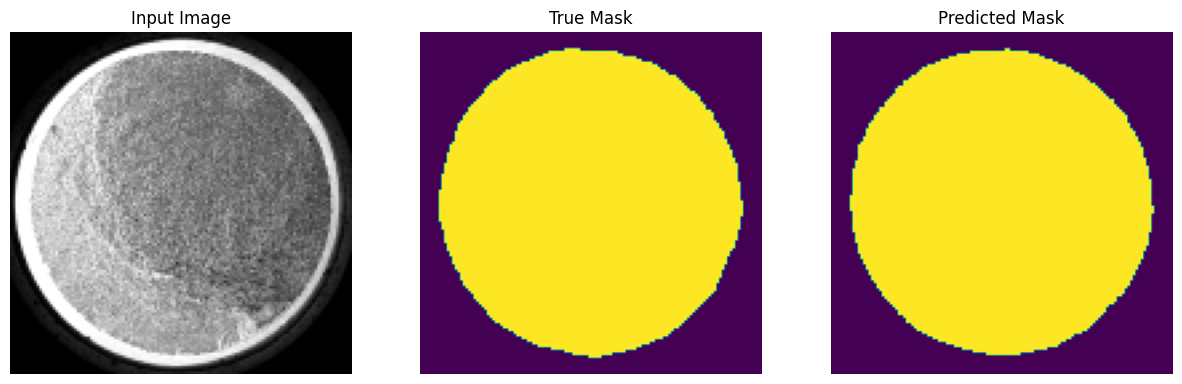


Sample Prediction after epoch 26

12/12 [==============================] - 4s 317ms/step - loss: 0.0195 - accuracy: 0.9924 - val_loss: 0.0316 - val_accuracy: 0.9878
Epoch 27/200
1/1 [==============================] - 0s 178ms/step



Sample Prediction after epoch 27

12/12 [==============================] - 3s 278ms/step - loss: 0.0194 - accuracy: 0.9924 - val_loss: 0.0315 - val_accuracy: 0.9880
Epoch 28/200
1/1 [==============================] - 0s 177ms/step


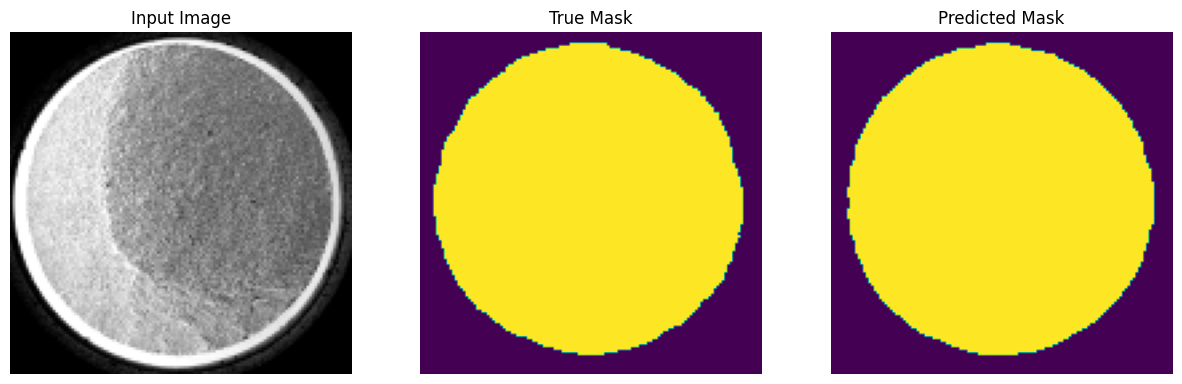


Sample Prediction after epoch 28

12/12 [==============================] - 3s 264ms/step - loss: 0.0191 - accuracy: 0.9926 - val_loss: 0.0329 - val_accuracy: 0.9877
Epoch 29/200
1/1 [==============================] - 0s 247ms/step


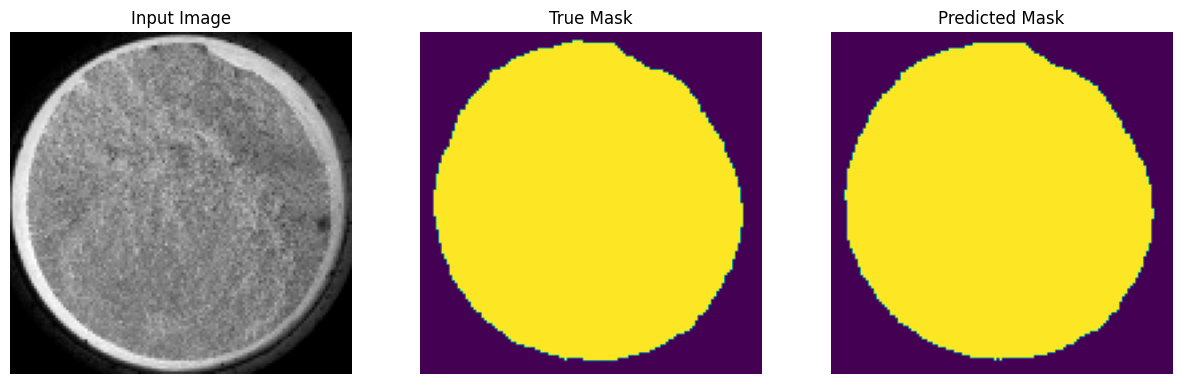


Sample Prediction after epoch 29

12/12 [==============================] - 3s 264ms/step - loss: 0.0191 - accuracy: 0.9925 - val_loss: 0.0321 - val_accuracy: 0.9877
Epoch 30/200
1/1 [==============================] - 0s 190ms/step


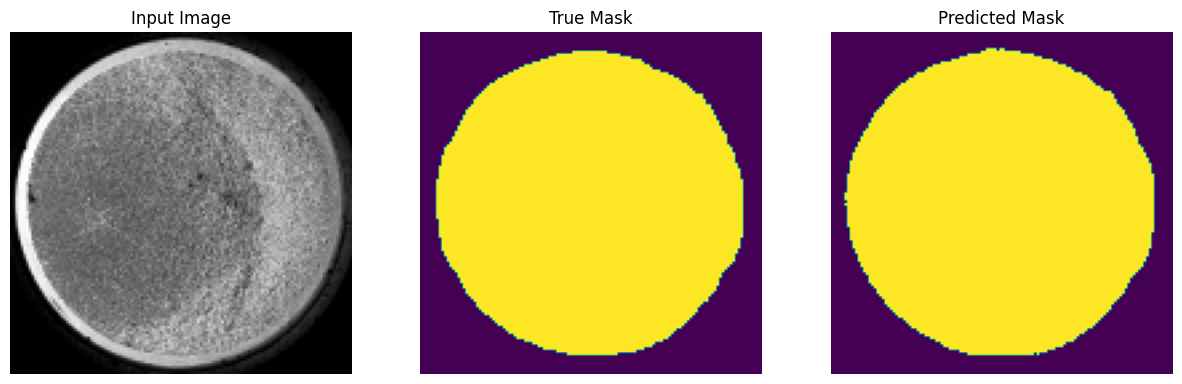


Sample Prediction after epoch 30

12/12 [==============================] - 3s 258ms/step - loss: 0.0176 - accuracy: 0.9930 - val_loss: 0.0314 - val_accuracy: 0.9880
Epoch 31/200
1/1 [==============================] - 0s 179ms/step


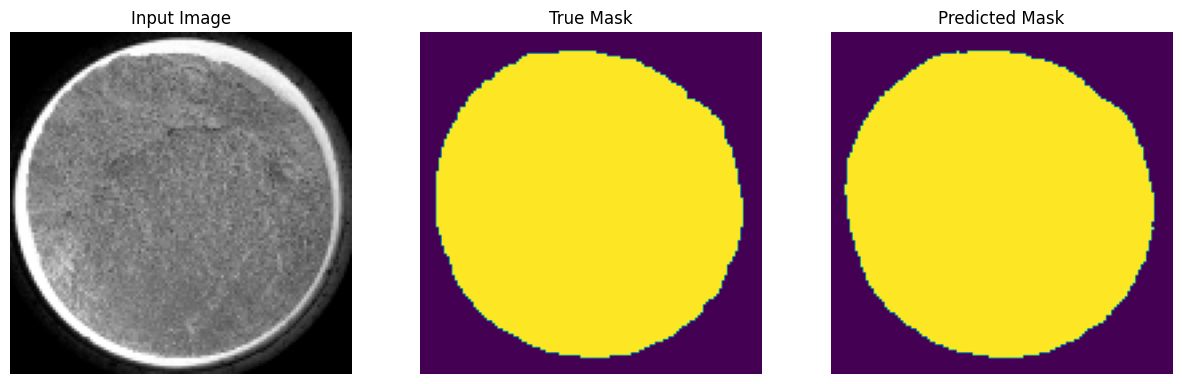


Sample Prediction after epoch 31

12/12 [==============================] - 3s 263ms/step - loss: 0.0173 - accuracy: 0.9932 - val_loss: 0.0317 - val_accuracy: 0.9881
Epoch 32/200
1/1 [==============================] - 0s 162ms/step


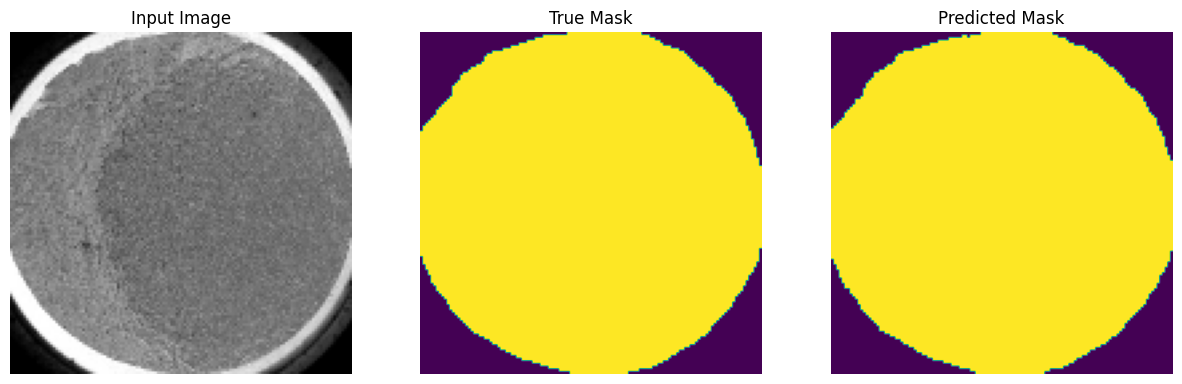


Sample Prediction after epoch 32

12/12 [==============================] - 3s 257ms/step - loss: 0.0160 - accuracy: 0.9939 - val_loss: 0.0320 - val_accuracy: 0.9879
Epoch 33/200
1/1 [==============================] - 0s 151ms/step


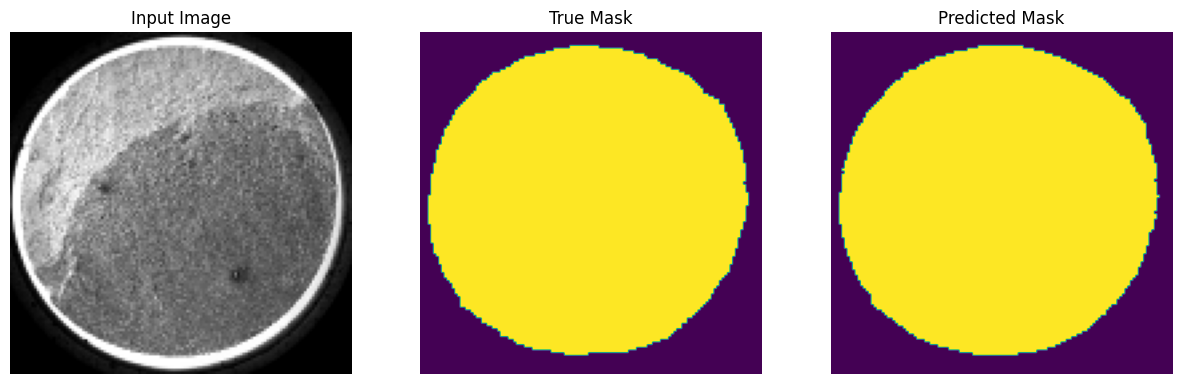


Sample Prediction after epoch 33

12/12 [==============================] - 3s 263ms/step - loss: 0.0161 - accuracy: 0.9938 - val_loss: 0.0318 - val_accuracy: 0.9885
Epoch 34/200
1/1 [==============================] - 0s 133ms/step


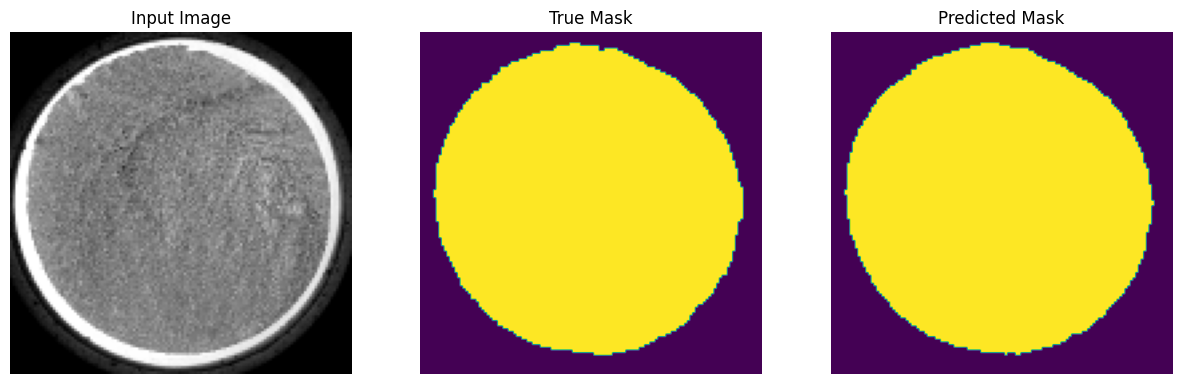


Sample Prediction after epoch 34

12/12 [==============================] - 3s 249ms/step - loss: 0.0159 - accuracy: 0.9938 - val_loss: 0.0338 - val_accuracy: 0.9878
Epoch 35/200
1/1 [==============================] - 0s 141ms/step


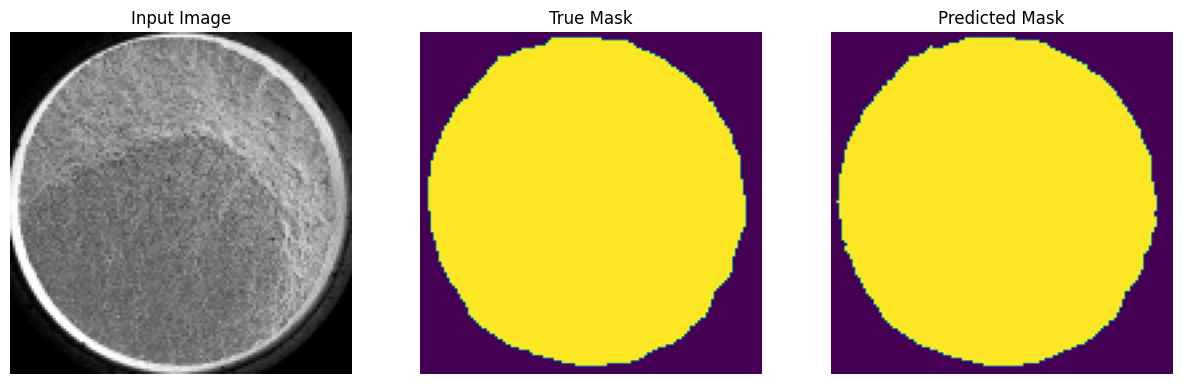


Sample Prediction after epoch 35

12/12 [==============================] - 3s 269ms/step - loss: 0.0160 - accuracy: 0.9937 - val_loss: 0.0330 - val_accuracy: 0.9877
Epoch 36/200
1/1 [==============================] - 0s 157ms/step


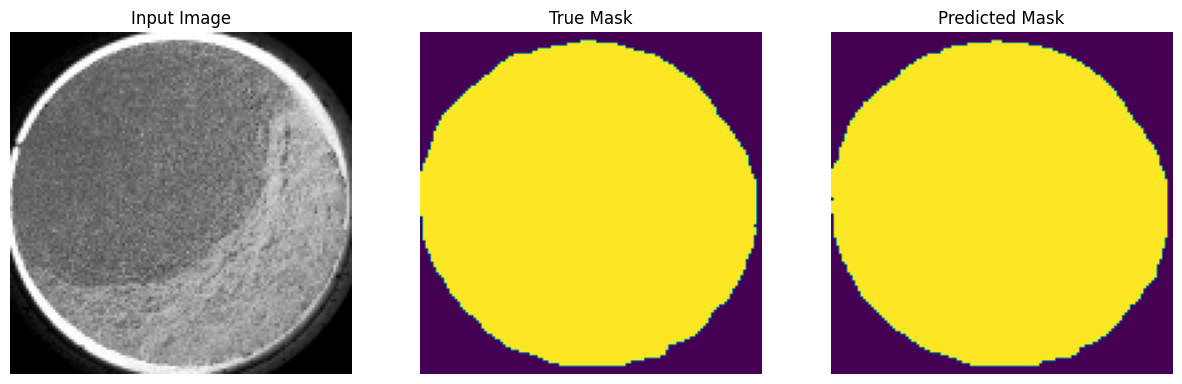


Sample Prediction after epoch 36

12/12 [==============================] - 3s 266ms/step - loss: 0.0166 - accuracy: 0.9934 - val_loss: 0.0316 - val_accuracy: 0.9878
Epoch 37/200
1/1 [==============================] - 0s 151ms/step


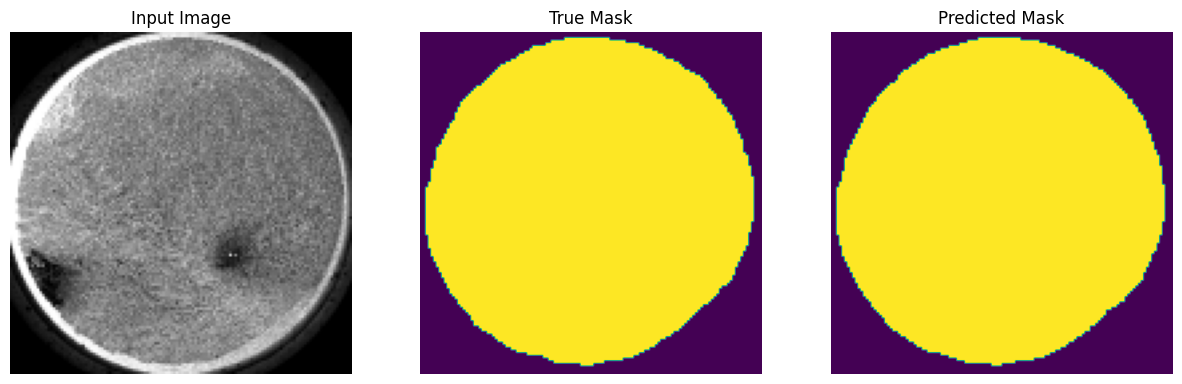


Sample Prediction after epoch 37

12/12 [==============================] - 3s 258ms/step - loss: 0.0155 - accuracy: 0.9939 - val_loss: 0.0323 - val_accuracy: 0.9883
Epoch 38/200
1/1 [==============================] - 2s 2s/step


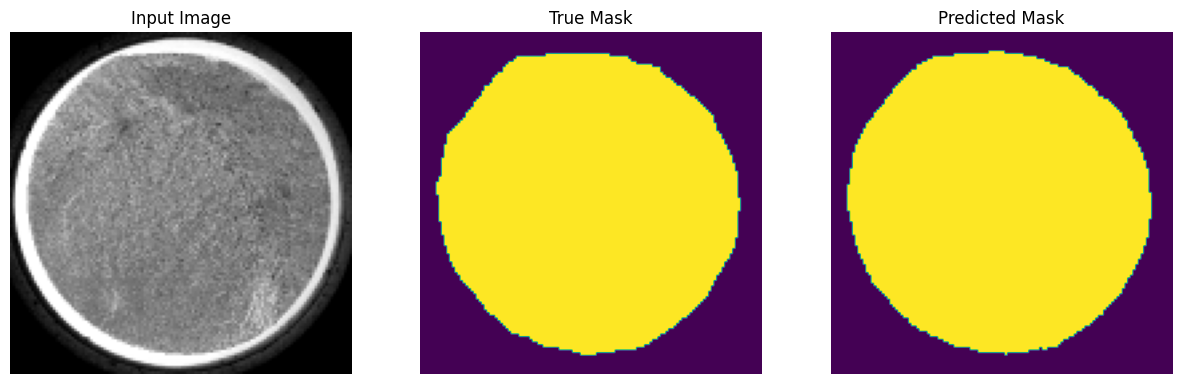


Sample Prediction after epoch 38

12/12 [==============================] - 5s 458ms/step - loss: 0.0138 - accuracy: 0.9947 - val_loss: 0.0332 - val_accuracy: 0.9881
Epoch 39/200
1/1 [==============================] - 0s 133ms/step


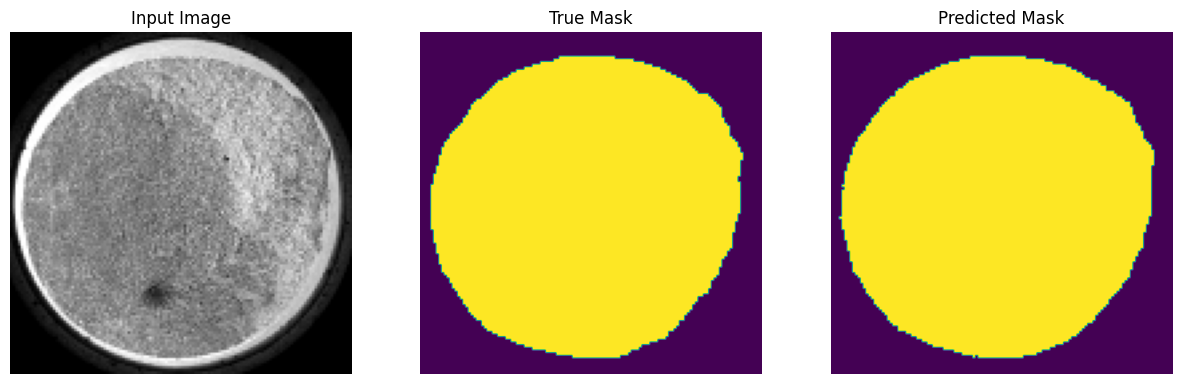


Sample Prediction after epoch 39

12/12 [==============================] - 3s 295ms/step - loss: 0.0139 - accuracy: 0.9946 - val_loss: 0.0332 - val_accuracy: 0.9877


In [23]:
from keras.callbacks import EarlyStopping

EPOCHS = 200
VAL_SUBSPLITS = 5
VALIDATION_STEPS = len(X_test) // 2 // BATCH_SIZE
STEPS_PER_EPOCH = len(X_train) // BATCH_SIZE

early_stopping = EarlyStopping(
    monitor='val_loss',  # The metric to monitor (e.g., validation loss)
    patience=20,         # Number of epochs to wait without improvement
    restore_best_weights=True  # Restore the model to the best weights
)

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=val_batches,
                          callbacks=[DisplayCallback(), early_stopping])

In [24]:
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np

# Evaluate the model
loss, acc = model.evaluate(test_batches, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

# Initialize the Mean IoU and F-beta score metrics
iou = tf.keras.metrics.MeanIoU(num_classes=2)
# Initialize FBetaScore for binary classification with beta=2 for more weight on recall
f1beta_score = tfa.metrics.FBetaScore(beta=0.5, num_classes=2, average='micro')


# Collect all predictions and labels to update F-beta score later
all_preds = []
all_labels = []

# Iterate through the test batches
for images, labels in test_batches:
    preds = model.predict(images)
    preds = tf.argmax(preds, axis=-1)  # Convert logits to class predictions
    preds = tf.cast(preds, tf.float32)  # Convert to float32

    # Update IoU with flattened labels and predictions
    iou.update_state(labels, preds)

    # Flatten the predictions and labels for consistency
    preds_flat = preds.numpy().flatten()
    labels_flat = labels.numpy().flatten()

    # Collect predictions and labels
    all_preds.extend(preds_flat)
    all_labels.extend(labels_flat)

# Convert lists to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Reshape the flattened arrays into 2D format expected by FBetaScore
all_preds = all_preds.reshape(-1, 1)
all_labels = all_labels.reshape(-1, 1)

# Update the F-beta score state with the reshaped arrays
f1beta_score.update_state(all_labels, all_preds)

# Print the results
print("Mean IoU =", iou.result().numpy())

# Calculate the F-beta score (weighted F1 score with more emphasis on recall)
f1_beta_score = f1beta_score.result().numpy()
print(f"F-beta Score (β=1.5): {f1_beta_score:.4f}")


C:\Users\jonat\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


2/2 - 0s - loss: 0.0275 - accuracy: 0.9897 - 222ms/epoch - 111ms/step
Restored model, accuracy: 98.97%
1/1 [==============================] - 0s 95ms/step
Mean IoU = 0.97796464
F-beta Score (β=1.5): 0.9926


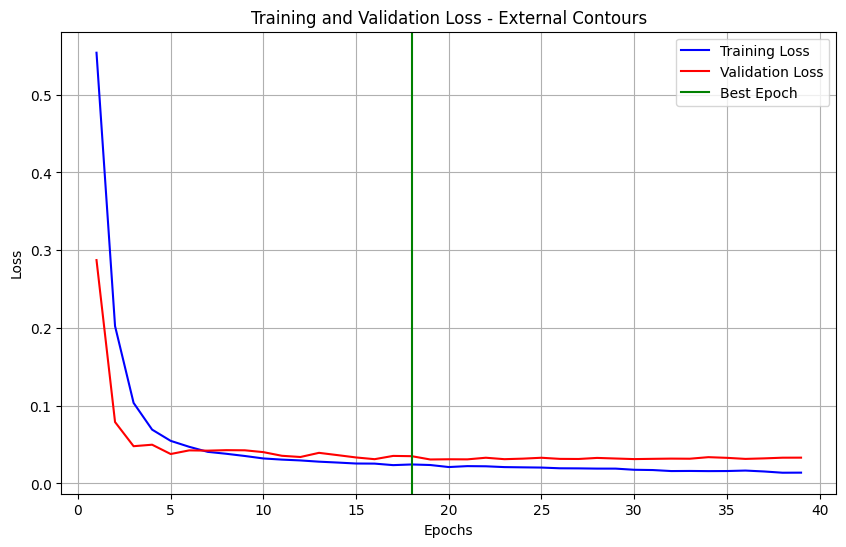

In [25]:
import matplotlib.pyplot as plt

# Extract data from the model history
train_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

# Create an array of the epoch numbers for the x-axis
epochs = range(1, len(train_loss) + 1)

# Plot the training loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.axvline(x=early_stopping.best_epoch, color='g', label='Best Epoch')
plt.title('Training and Validation Loss - External Contours')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

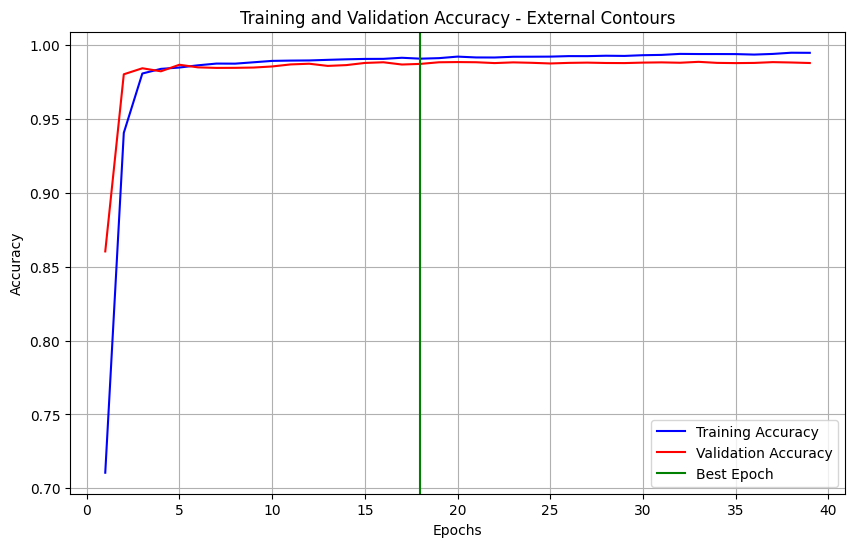

In [26]:
# Plot the training and testing accuracy
train_acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.axvline(x=early_stopping.best_epoch, color='g', label='Best Epoch')
plt.title('Training and Validation Accuracy - External Contours')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

In [27]:
# Save the model
tf.keras.models.save_model(model, 'external_mask_unet_model')

INFO:tensorflow:Assets written to: external_mask_unet_model\assets


INFO:tensorflow:Assets written to: external_mask_unet_model\assets


In [28]:
# print the number of the epoch as selected
# by the early stopping callback
print(early_stopping.best_epoch)

18
